In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import path

We are comparing std::shuffle vs fisher-yates vs fisher-yates_32 vs fisher_yates_64. We are running this on the unix machin at the universitiy.

In [4]:
# We load data
df_std_shuffle = pd.read_csv(path.join("..", "cpp", "20231213-020409-nb=0-bf=0-th=0-cpp.csv"))
df_fy_shuffle = pd.read_csv(path.join("..", "cpp", "20231213-021122-nb=0-bf=0-th=0-cpp.csv"))
df_fy_shuffle_32 = pd.read_csv(path.join("..", "cpp", "20231213-021932-nb=0-bf=0-th=0-cpp.csv"))
df_fy_shuffle_64 = pd.read_csv(path.join("..", "cpp", "20231213-022624-nb=0-bf=0-th=0-cpp.csv"))

In [5]:
# We calculate runtime per integer
df_std_shuffle["runtime/integer [ns]"] = (df_std_shuffle["total_runtime"] / df_std_shuffle["total_runs"]) / df_std_shuffle["integers"]
df_fy_shuffle["runtime/integer [ns]"] = (df_fy_shuffle["total_runtime"] / df_fy_shuffle["total_runs"]) / df_fy_shuffle["integers"]
df_fy_shuffle_32["runtime/integer [ns]"] = (df_fy_shuffle_32["total_runtime"] / df_fy_shuffle_32["total_runs"]) / df_fy_shuffle_32["integers"]
df_fy_shuffle_64["runtime/integer [ns]"] = (df_fy_shuffle_64["total_runtime"] / df_fy_shuffle_64["total_runs"]) / df_fy_shuffle_64["integers"]

Text(0.5, 1.0, 'Comapring some shhuffle algorithms for base case')

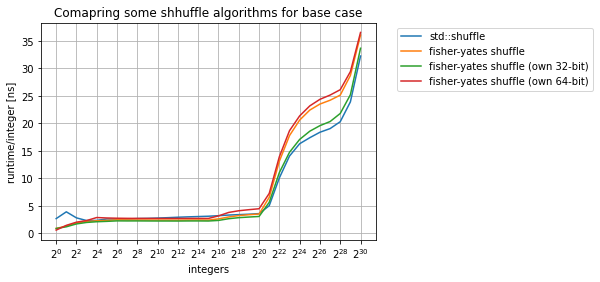

In [8]:
# We plot data
ax__xticks = [2 ** i for i in range(0, 31, 2)]
ax__yticks = [10 * i for i in range(0, 12, 1)]

ax = df_std_shuffle.plot(x="integers", y="runtime/integer [ns]", label="std::shuffle")
df_fy_shuffle.plot(ax=ax, x="integers", y="runtime/integer [ns]", label="fisher-yates shuffle")
df_fy_shuffle_32.plot(ax=ax, x="integers", y="runtime/integer [ns]", label="fisher-yates shuffle (own 32-bit)")
df_fy_shuffle_64.plot(ax=ax, x="integers", y="runtime/integer [ns]", label="fisher-yates shuffle (own 64-bit)")

ax.set_xscale("log", base=2)
# ax.set_yscale("log", base=10)
ax.set_xticks(ax__xticks)
# ax.set_yticks(ax__yticks)
ax.grid(True)
ax.set_xlabel("integers")
ax.set_ylabel("runtime/integer [ns]")
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_title("Comapring some shhuffle algorithms for base case")

The base_case algorithm is used when the buckets are smaller then the threshold. I increased the threshold so that it will be used for all meassured sizes. We see that the default settings for the sequentiell shuffle runs a bit faster than the base_case algorithm. It manages to beat it when we have more than 2^23 elements.

Now let's check my C++ results.

In [20]:
# We load data
cpp_reults = glob.glob(path.join("cpp", "MacBook", "v0.1.6", "*.csv"))
dfs_cpp = [pd.read_csv(f) for f in cpp_reults]
df_cpp = pd.concat(dfs_cpp, ignore_index=True)

In [21]:
# Format data
df_cpp_mean = df_cpp.groupby(["buckets", "threshold", "integers"], as_index=False)[["duration [ns]"]].mean()

# We calculate runtime per integer
df_cpp_mean["runtime per integer [ns]"] = df_cpp_mean["duration [ns]"] / df_cpp_mean["integers"]

Text(0.5, 1.0, 'Comparing multiple parameters for seq_shuffle in C++')

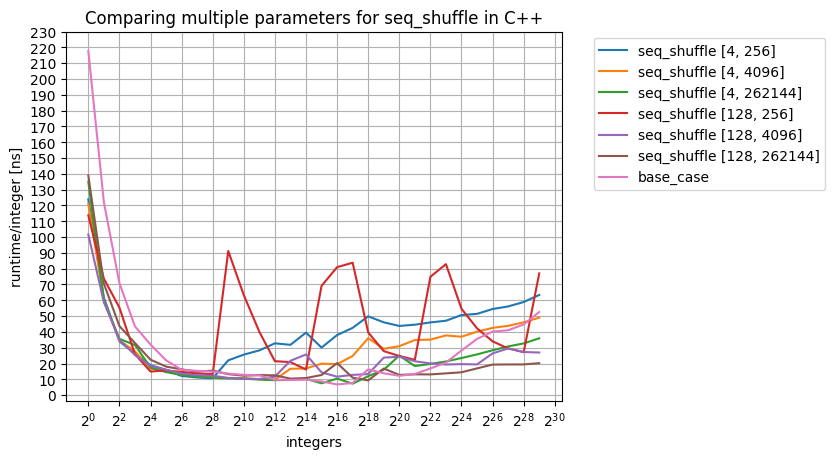

In [29]:
# We plot data
ax_cpp_xticks = [2 ** i for i in range(0, 31, 2)]
ax_cpp_yticks = [10 * i for i in range(0, 24, 1)]

ax_cpp = df_cpp_mean.query("buckets == 4 & threshold == 256").plot(x="integers", y="runtime per integer [ns]", label="seq_shuffle [4, 256]")
df_cpp_mean.query("buckets == 4 & threshold == 4096").plot(ax=ax_cpp, x="integers", y="runtime per integer [ns]", label="seq_shuffle [4, 4096]")
df_cpp_mean.query("buckets == 4 & threshold == 262144").plot(ax=ax_cpp, x="integers", y="runtime per integer [ns]", label="seq_shuffle [4, 262144]")
df_cpp_mean.query("buckets == 128 & threshold == 256").plot(ax=ax_cpp, x="integers", y="runtime per integer [ns]", label="seq_shuffle [128, 256]")
df_cpp_mean.query("buckets == 128 & threshold == 4096").plot(ax=ax_cpp, x="integers", y="runtime per integer [ns]", label="seq_shuffle [128, 4096]")
df_cpp_mean.query("buckets == 128 & threshold == 262144").plot(ax=ax_cpp, x="integers", y="runtime per integer [ns]", label="seq_shuffle [128, 262144]")
df_cpp_mean.query("buckets == 128 & threshold == 1073741824").plot(ax=ax_cpp, x="integers", y="runtime per integer [ns]", label="base_case")

ax_cpp.set_xscale("log", base=2)
# ax_cpp.set_yscale("log", base=10)
ax_cpp.set_xticks(ax_cpp_xticks)
ax_cpp.set_yticks(ax_cpp_yticks)
ax_cpp.grid(True)
ax_cpp.set_xlabel("integers")
ax_cpp.set_ylabel("runtime/integer [ns]")
ax_cpp.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax_cpp.set_title("Comparing multiple parameters for seq_shuffle in C++")

These are my best results so far. Like in the Rust code, the sequential shuffle follows the base_case algorithm and overtakes it when we reach 2^22 elements. The base_case algorithm seems to be very slow for very small sizes. I assume that the overhead of my seq_shuffle is too big? In theory, we won't have to call it for such small cases but ratther for cases in the near of the threshold.

We can also see that my code is twice as slow as the Rust one. Let's compare both base_case algorithms and the best performing seq_shuffle (keeping the same parameterss, eg 128 buckets and a threshold of 262144.

In [33]:
df_rust_base = pd.read_csv(path.join("rust", "MacBook", "20231022-155834-nb=128-th=1073741824-r.csv"))
df_rust_seq = pd.read_csv(path.join("rust", "MacBook", "20231022-155350-nb=128-th=262144-r.csv"))
df_cpp_base = pd.read_csv(path.join("cpp", "MacBook", "v0.1.6", "20231022-181347-nb=128-bf=256-th=1073741824-cpp.csv"))
df_cpp_seq = pd.read_csv(path.join("cpp", "MacBook", "v0.1.6", "20231018-174448-nb=128-bf=256-th=262144-cpp.csv"))

In [34]:
# Format data
df_rust_base_mean = df_rust_base.groupby(["buckets", "threshold", "integers"], as_index=False)[["duration [ns]"]].mean()
df_rust_seq_mean = df_rust_seq.groupby(["buckets", "threshold", "integers"], as_index=False)[["duration [ns]"]].mean()
df_cpp_base_mean = df_cpp_base.groupby(["buckets", "threshold", "integers"], as_index=False)[["duration [ns]"]].mean()
df_cpp_seq_mean = df_cpp_seq.groupby(["buckets", "threshold", "integers"], as_index=False)[["duration [ns]"]].mean()

# We calculate runtime per integer
df_rust_base_mean["runtime per integer [ns]"] = df_rust_base_mean["duration [ns]"] / df_rust_base_mean["integers"]
df_rust_seq_mean["runtime per integer [ns]"] = df_rust_seq_mean["duration [ns]"] / df_rust_seq_mean["integers"]
df_cpp_base_mean["runtime per integer [ns]"] = df_cpp_base_mean["duration [ns]"] / df_cpp_base_mean["integers"]
df_cpp_seq_mean["runtime per integer [ns]"] = df_cpp_seq_mean["duration [ns]"] / df_cpp_seq_mean["integers"]

Text(0.5, 1.0, 'Comparing base_case and seq_shuffle of both langugaes')

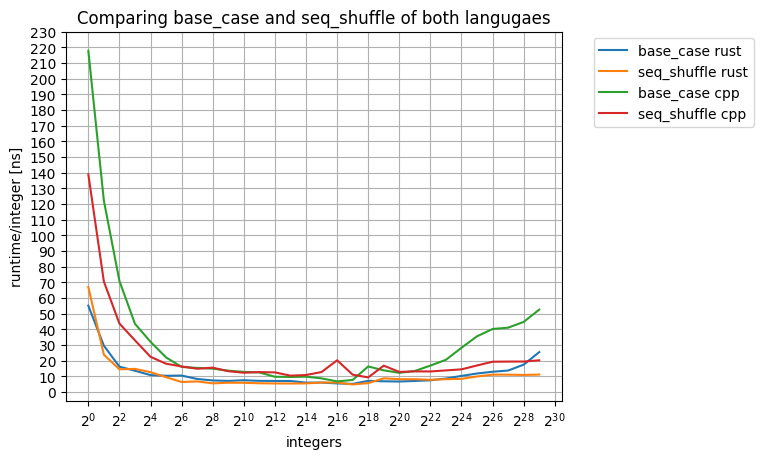

In [35]:
# We plot data
ax_compare_xticks = [2 ** i for i in range(0, 31, 2)]
ax_compare_yticks = [10 * i for i in range(0, 24, 1)]

ax_compare = df_rust_base_mean.plot(x="integers", y="runtime per integer [ns]", label="base_case rust")
df_rust_seq_mean.plot(ax=ax_compare, x="integers", y="runtime per integer [ns]", label="seq_shuffle rust")
df_cpp_base_mean.plot(ax=ax_compare, x="integers", y="runtime per integer [ns]", label="base_case cpp")
df_cpp_seq_mean.plot(ax=ax_compare, x="integers", y="runtime per integer [ns]", label="seq_shuffle cpp")

ax_compare.set_xscale("log", base=2)
# ax_cpp.set_yscale("log", base=10)
ax_compare.set_xticks(ax_compare_xticks)
ax_compare.set_yticks(ax_compare_yticks)
ax_compare.grid(True)
ax_compare.set_xlabel("integers")
ax_compare.set_ylabel("runtime/integer [ns]")
ax_compare.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax_compare.set_title("Comparing base_case and seq_shuffle of both langugaes")

Performance of my implementation is quite bad for small sizes. For sizes above 2^6 it is quite close though. Around twice as slow than the Rust code. 

Maybe we should lower the buffer size! Looking at 02_anaylsis.ipynb shows that this might cause ths.